# Practical session n°5

Notions:
- Quantile regression
- Pinball Loss


Duration: 1 h 30

In this practical, we immerse ourselves again in the context where the training inputs ($x$) and targets ($y$) are images of the same spatial dimensions. However, we assume that the dependence of $y$ on $x$ is probabilistic in nature. In other words, there exist conditional laws $p(y | x)$, and these laws need to be characterized.

Here, we limit ourselves to conditional marginals, meaning the laws $p(y_{i,j} | x)$ where $y_{i,j}$ represents the value of the target $y$ at the pixel $(i,j)$. To characterize these laws, several approaches are possible. For instance, one can attempt to estimate their quantiles or moments. The following exercises illustrate a method for estimating quantiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [4]:
#! git clone https://github.com/nanopiero/ML_S5_etudiants
import sys
sys.path.append('ML_S5_etudiants/practicals/P5')
from utils_P5 import gen_proba, voir_batch2D, UNet

**Exercise 1**: on the PINBALL loss

As seen in the previous practical session n°4, using the Mean Absolute Error (MAE) led the model to provide the conditional median, which is a particular quantile. To estimate other quantiles, it is sufficient to modify the MAE.

This is what we are going to do on a simple problem where the link between the input and the target is defined by:
$$y_{i,j} \sim \mathcal{N}(\mu(x_{i,j}), \sigma(x_{i,j})) $$
where $\mu$ and $\sigma$ are a priori unknown.

The gen_proba function from the utile.py module will allow us to "explore" our dataset, or in other words, to sample the random pair $(x, y)$.

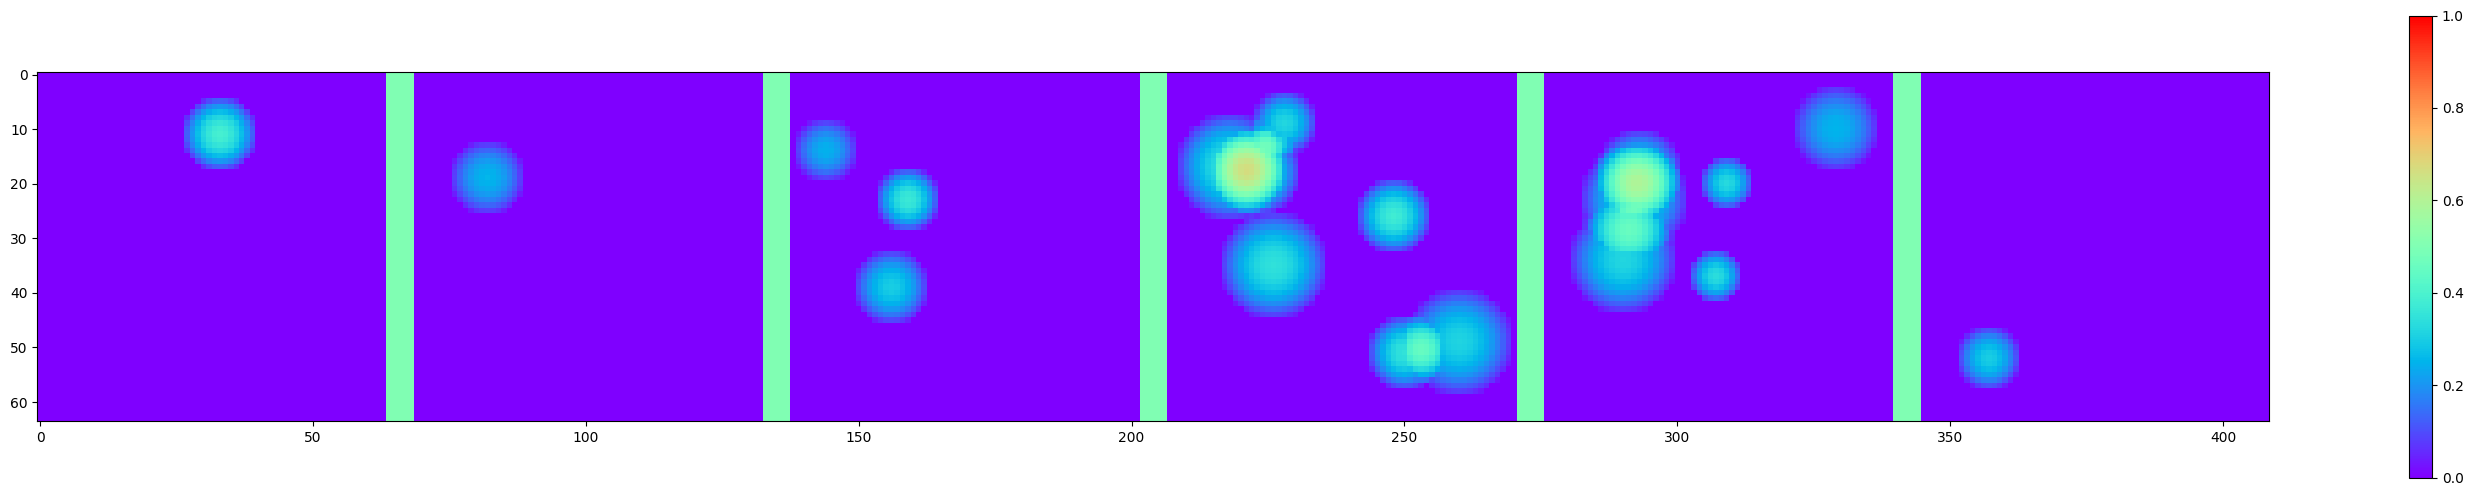

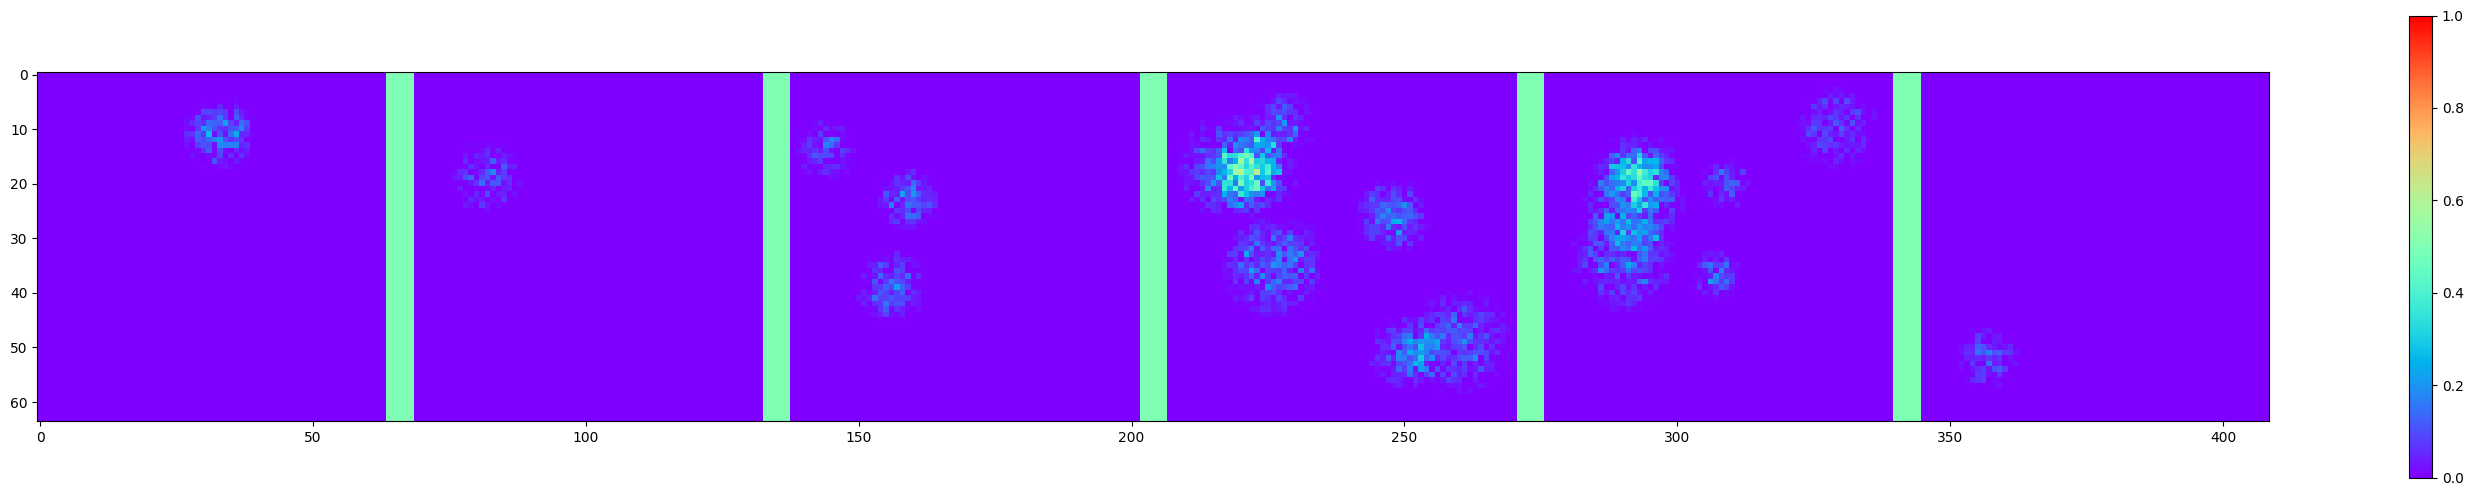

In [5]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Let's consider the cost function be defined at the pixel level by:
$$\mathcal{L}_t(y,z) =  \rho_t(z - y) $$  
where:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$

**Q1** Plot the graph of $\rho_t$ for different values of $t$ in the range [0, 1] using *matplotlib.pyplot*.
How does $\mathcal{L}_t$ generalize the MAE?

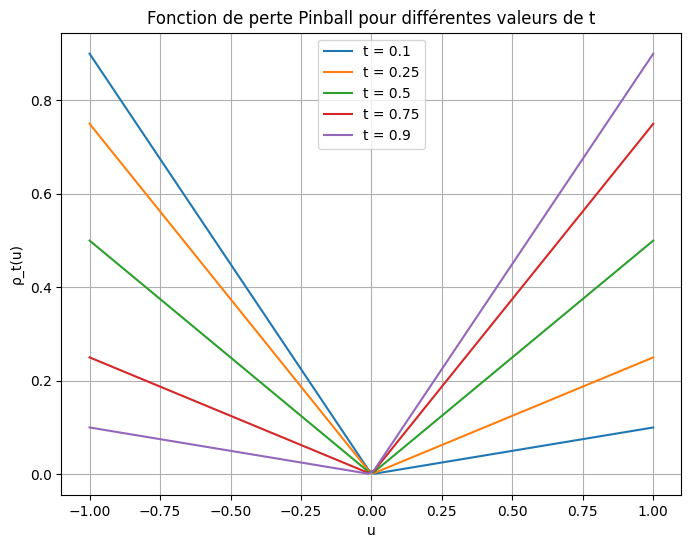

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def rho(u, t):
    return t * np.maximum(u, 0) + (t - 1) * np.minimum(u, 0)

# Différentes valeurs de t
t_values = [0.1, 0.25, 0.5, 0.75, 0.9]

# Valeurs de u
u_values = np.linspace(-1, 1, 100)

# Tracer le graphique
plt.figure(figsize=(8, 6))
for t in t_values:
    plt.plot(u_values, rho(u_values, t), label=f't = {t}')

plt.xlabel('u')
plt.ylabel('ρ_t(u)')
plt.title('Fonction de perte Pinball pour différentes valeurs de t')
plt.legend()
plt.grid(True)
plt.show()

**Q2** In the following cell, code a cost function adapted to the estimation of $t$-th quantiles (use *.clamp*( ))

In [7]:


def rho(u, t):
    return t * torch.clamp(u, min=0) + (t - 1) * torch.clamp(u, max=0)

**Q3** Train a U-Net to estimate the ninth decile.

In [22]:
def criterion(output, target):
  loss = rho(target-output, 0.6)
  return torch.mean(loss)


In [23]:
fcn = UNet(1,1,8).cuda()
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [24]:
nepochs = 5
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):

        input, target = gen_proba(batchsize)

        optimizer.zero_grad()
        output = fcn(input.cuda())
        loss = criterion(output, target.cuda())
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.0237959
Epoch 1
epoch loss : 

0.0070888437
Epoch 2
epoch loss : 

0.006248913
Epoch 3
epoch loss : 

0.00609083
Epoch 4
epoch loss : 

0.0056515257


**Q4** The ground truth is given by:
$$ \mu(x_{i,j}) = {x}_{i,j}^2 $$
and
$$ \sigma(x_{i,j}) = 0.2 \times x_{i,j} $$

Use [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) to verify that the result corresponds well to the expected quantile.

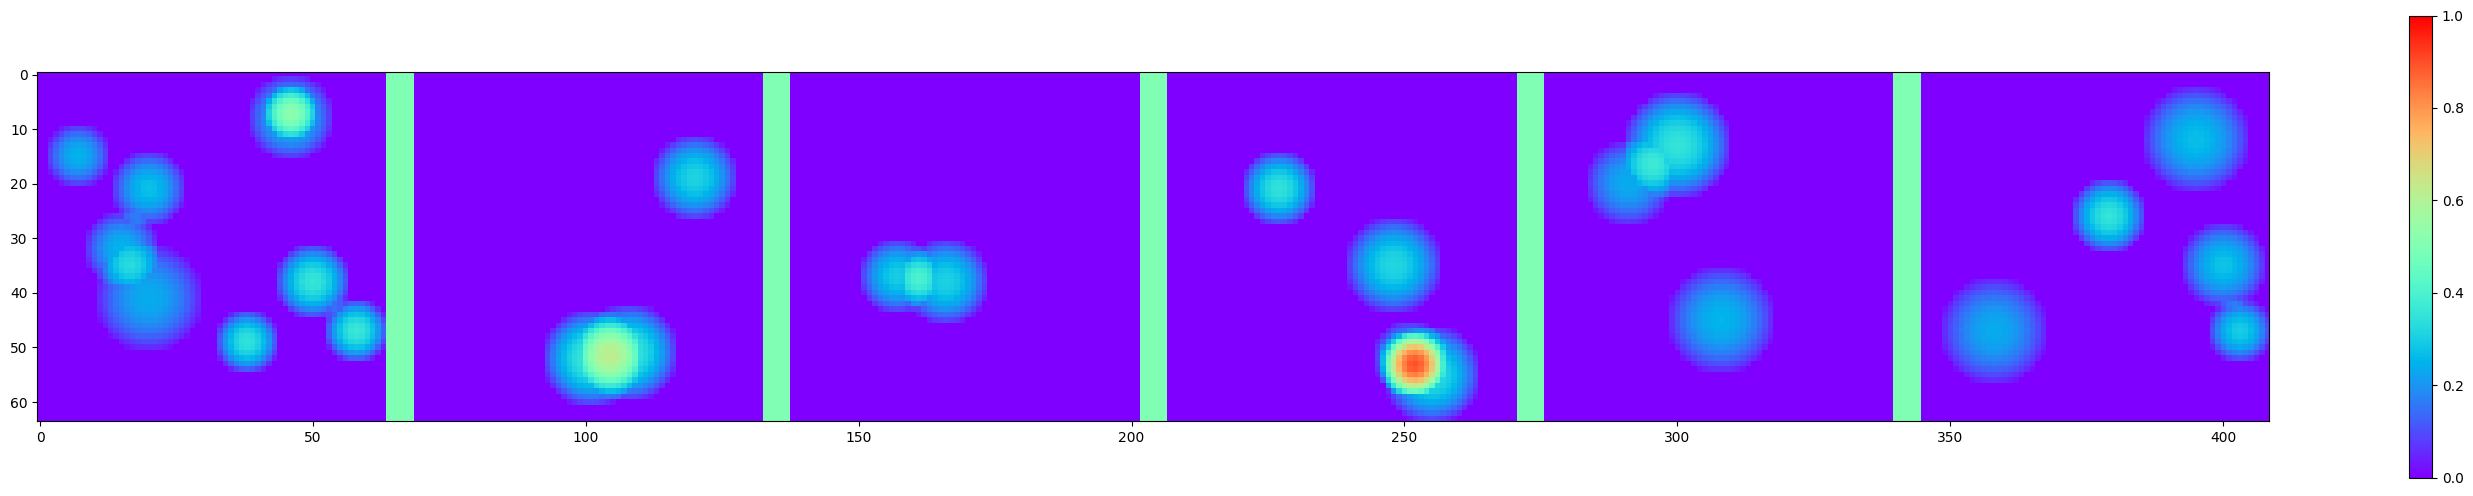

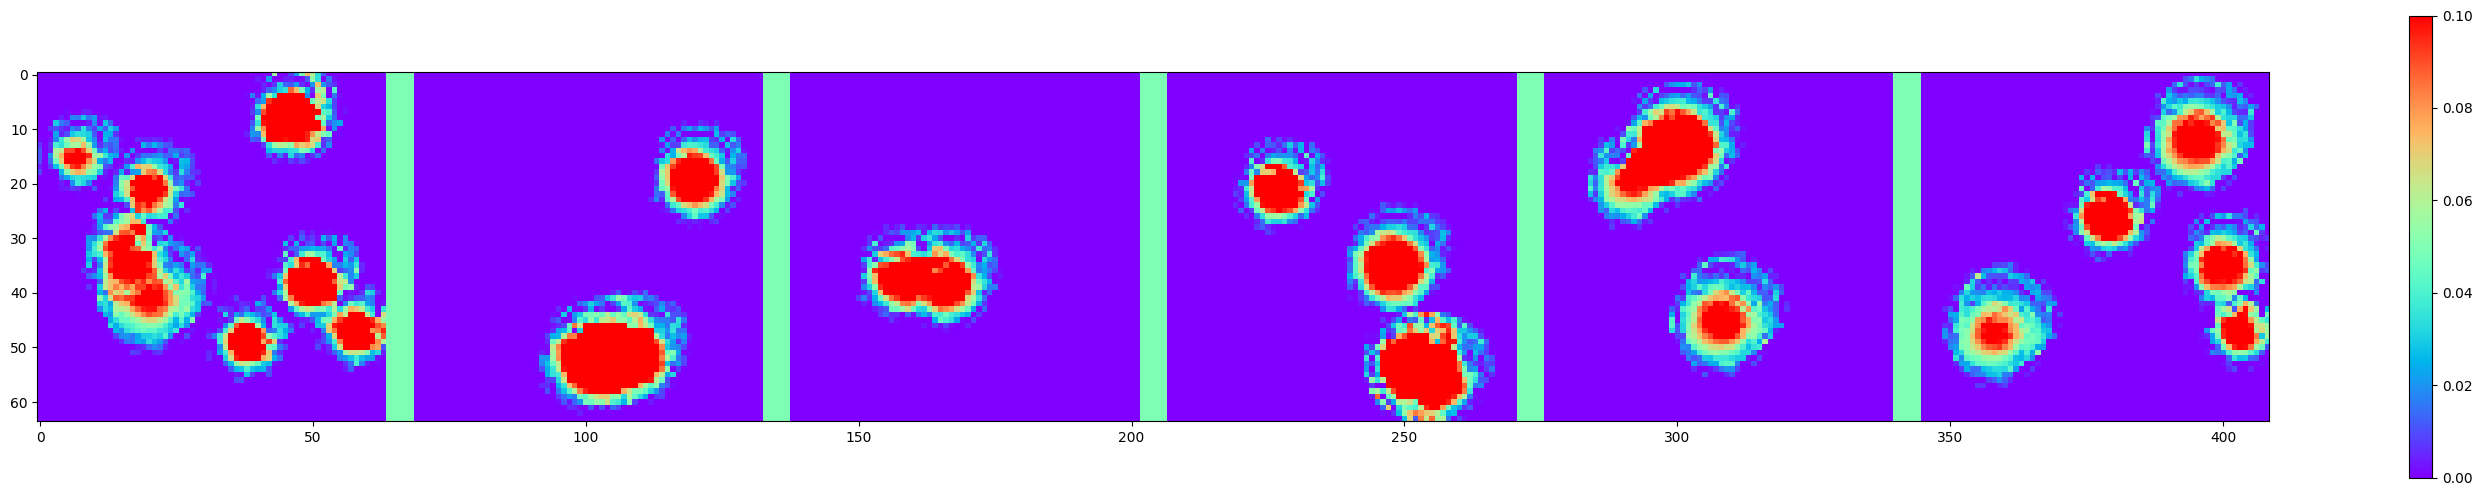

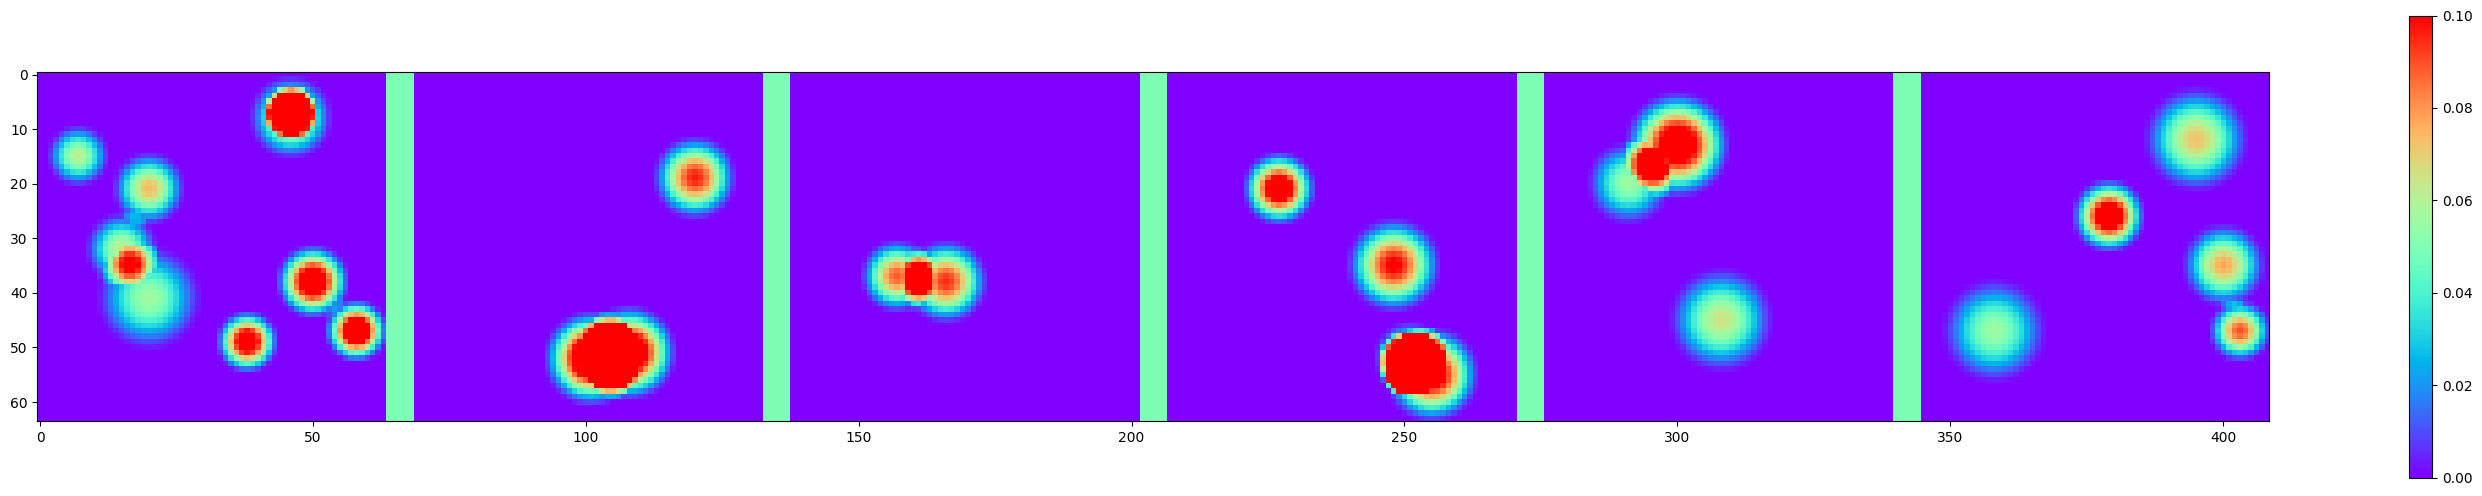

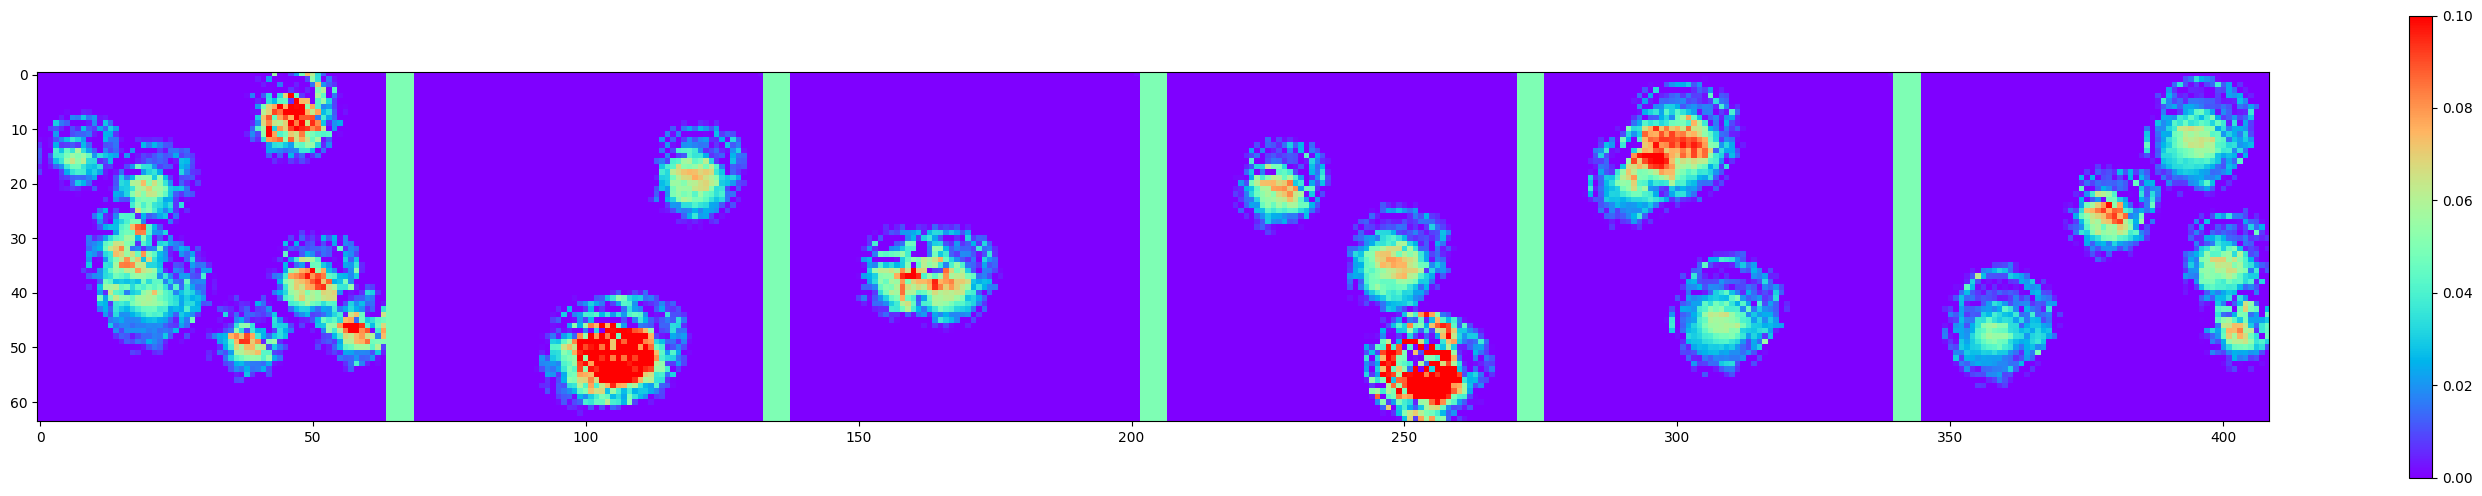

In [25]:
# viz:
fcn.eval()
input, target = gen_proba(6)
output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1) # inputs
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=0,max_scale=0.1) # outputs

# true quantile
true_quantiles = torch.pow(input, 2)

fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(true_quantiles, 6, fig2, k=0, min_scale=0.,max_scale=0.1) # ninth decile
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output.detach().cpu() - true_quantiles, 6, fig2, k=0, min_scale=0,max_scale=0.1) # outputs - ninth decile


**Exercise 2**: a trickier dependence

Let's now work with the following *gen_proba_2* function.

In [ ]:
from utils_P5 import make_batch
def gen_proba_2(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0015)
  target2 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  m = torch.normal(2, 2. + target2)
  input = target1 + target2
  target = m
  return  input, target


Here, the dependence of $y$ upon $x$ is not clearly visible in the input-target pairs:

In [ ]:
input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

**Q1** Estimate the 0.1 quantiles of the marginal distributions and visualize the result.

In [ ]:
def criterion(output, target):
  return rho(target-output, 0.1)  #on vise le premier décile

nepochs = 50
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize

        ...

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

In [ ]:
#visualisation:

fcn.eval()

input, target = gen_proba_2(6)

...

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=-1,max_scale=0)

**Q2** Do outputs depend on inputs? Is it a pixel-wise dependence as in exercise 1? (i.e., does the distribution of $y_{i,j}$ depend only on $x_{i,j}$)



**Exercise 3**:

One can attempt to estimate $n$ quantiles simultaneously. To achieve this, the simplest way is to:

* change the number of output channels of the U-Net—e.g., 99 channels if you are estimating the $n = 100$ quantiles of orders 1%, 2%, ... 99%.
* define the overall cost function by summing individual cost functions for each of the channels.
The goal of this exercise is to code a matrix version of this overall cost function and illustrate the convergence of the learning process.


**Q1** Let $t$ be a vector of size $n-1$, and $M$ be a 4th-order tensor. Code the function: $$dot(t, M) = M^{\prime}$$ where: $$M^{\prime}_{b,i,j} = \underset{0<c<n}{\sum} t_c \times M_{b,c,i,j}$$.

This function will allow to apply $\rho_{t_c}$ (see **Exercise 1**) to each channel $c$ of the output $M$ (where $b$ represents the batch index and $i,j$ represent spatial dimensions).

In [ ]:
def dot(t, M):
	return ...

**Q2** Complete the class *QuantileLoss*:

In [ ]:
class QuantileLoss(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = torch.arange(1/n,1,1/n).cuda()  # quantile orders

    def forward(self, output, target):
        bs, _, nx, ny = target.shape
        ...
        loss = torch.mean(loss_by_pix)

        return loss

**Q3** Start the training with *gen_proba* and $n=100$, then evaluate the estimation.